<a href="https://colab.research.google.com/github/chequanghuy/CS114.K21/blob/master/%C4%90%E1%BB%93%20%C3%A1n/Code/plateDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import thư viện

**import thư viện**

In [ ]:
import numpy as np
import cv2 
import sys
import os
from sklearn import svm
from sklearn.externals import joblib
from sklearn import metrics
import shutil

# Di chuyển đến drive

**Trỏ tới Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab\ Notebooks/Doan/plate_bike

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Define một số biến**

In [ ]:
plate_cascade = cv2.CascadeClassifier('weight/cascade.xml')

PATH = "images"
PATH_WEIGHT = "weight"
# Ghi ảnh
DEBUG = True

# Vị trí của mảng tương ứng với nhãn của ký tự, ví dụ vị trí 10 là nhãn A
LABELS = ['0','1','2','3','4','5','6','7','8','9', 'A','B','C','D','E',
        'F','G','H','I','J','K','L','M','N','O','P','Q',
        'R','S','T','U','V','W','X','Y','Z']

# Đọc ảnh và tìm ra vùng chứa biển số xe

**Đọc ảnh**

In [ ]:
img = cv2.imread('images/IMG_20190606_114544.jpg')

**Resize và show ảnh**

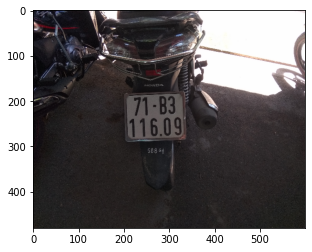

In [ ]:
import matplotlib.pyplot as plt 
img=cv2.resize(img,(600,480))
plt.figure()
plt.imshow(cv2.cvtColor(img , cv2.COLOR_BGR2RGB))
plt.show() 

**Chuyển về ảnh xám**

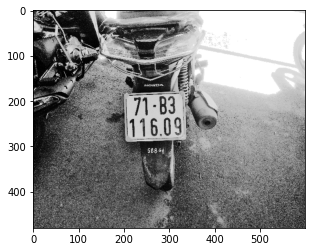

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #chuyển sang ảnh xám
gray = cv2.equalizeHist(gray)   #cân bằng các giá trị cường độ có trong bức ảnh
plt.figure()
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
plt.show() 

**Detect và in số lượng biển số xe detect được**

In [ ]:
plates = plate_cascade.detectMultiScale(gray, 1.1, 3)   #nhận diện biển số từ file xml
print(len(plates))

1


# Tiền xử lý ảnh để lấy được vị trí của các ký tự trên biển số xe

**Lấy vùng chứa biển số xe**

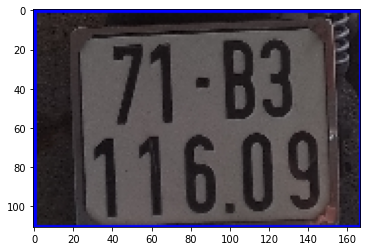

In [ ]:
for (x,y,w,h) in plates:
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)    
    roi = img[y:y+h, x:x+w]     #crop hình chứa biển số
    plt.figure()
    plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    plt.show() 

**Tiền xử lý ảnh vùng đã detect**

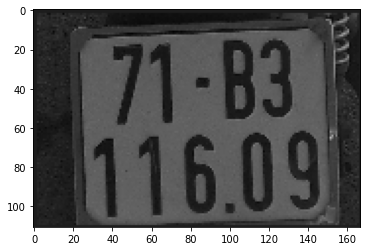

In [ ]:
# Chuyển ảnh BGR sang ảnh xám 

roi_gray = cv2.cvtColor(roi,cv2.COLOR_BGR2GRAY)     #converse ảnh vừa crop sang ảnh xám
plt.figure()
plt.imshow(cv2.cvtColor(roi_gray, cv2.COLOR_BGR2RGB))
plt.show() 

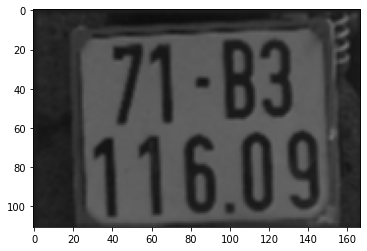

In [ ]:
roi_blur = cv2.GaussianBlur(roi_gray,(3,3),1)
plt.figure()
plt.imshow(cv2.cvtColor(roi_blur, cv2.COLOR_BGR2RGB))
plt.show() 

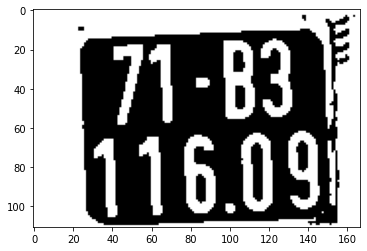

In [ ]:
# Dùng THRESH_BINARY_INV đưa ảnh về trắng đen
# ret,thre = cv2.threshold(roi_blur,170,255,cv2.THRESH_BINARY_INV)
ret, thre = cv2.threshold(roi_blur,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
plt.figure()
plt.imshow(cv2.cvtColor(thre, cv2.COLOR_BGR2RGB))
plt.show() 

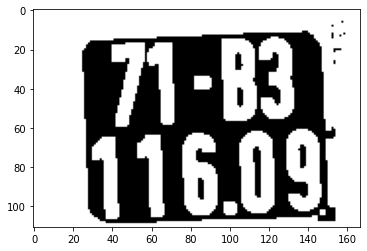

In [ ]:
kerel3 = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))    #tạo một ma trận 3*3
thre_mor = cv2.morphologyEx(thre,cv2.MORPH_DILATE,kerel3)   #dilate(giãn nở)
thre_mor =cv2.resize(thre_mor ,((int(thre_mor .shape[1]*(600.0/img.shape[1]))),int(thre_mor .shape[0]*(480.0/img.shape[0]))))
plt.figure()
plt.imshow(cv2.cvtColor(thre_mor, cv2.COLOR_BGR2RGB))
plt.show() 

**Tìm tất cả countour là ký tự cần quan tâm trên ảnh**

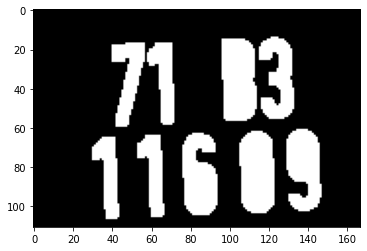

In [ ]:
# Tìm tất cả các contours trên ảnh
mask = np.zeros(thre_mor.shape, np.uint8)
cont, hier = cv2.findContours(thre_mor,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
# Xác định các contours là ký tự, biển xe máy VN có 8 ký tự
areas_ind = {}  #khai báo một dictionary để lưu index
areas = []  #khai báo một mảng để lưu contourArea
for ind,cnt in enumerate(cont) :
    area = cv2.contourArea(cnt) #tìm diện tích của các contour 
    # print(area, roi_gray.shape[0] * roi_gray.shape[1])
    #xác định chính xác xem đây có phải là ký tự trên biển số hay không
    if((roi_gray.shape[0] * roi_gray.shape[1]) - area < 2000):
        continue    
    else:
        areas_ind[area] = ind   #ứng với diện tích đó thì sẽ lưu lại với key là index
        areas.append(area)      #thêm giá trị của area (diện tích) vào mảng 
areas = sorted(areas,reverse=True)  #sắp xếp lại mảng

if areas[9]>250:                #xác định đây là biển 9 số hay 8 số
    areas=areas[1:10]
else:
    areas=areas[1:9]

for c,i in enumerate(areas):
    cv2.drawContours(mask, [cont[areas_ind[i]]], -1, 255, -1)
    
plt.figure()
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
plt.show() 

# Nhận dạng ký tự có trên biển số xe

**Lấy ra từng vị trí countour đã tìm được ở bước trước sau đó predict bằng model svm đã train từ trước**

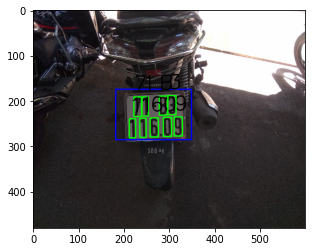

In [ ]:
# Tạo ma trận rộng có kích thước bằng kích thước ảnh đầu vào
mask_num = np.zeros(img.shape, np.uint8)
arrs=[]
# Nhận diện ký tự vừa xác định
plate = []
for c,i in enumerate(areas):    
    x1,y1,w1,h1 = cv2.boundingRect(cont[areas_ind[i]])
    # Vẽ contour biển số đã lọc lên ảnh và hiển thị
    cv2.drawContours(mask_num, [cont[areas_ind[i]]], -1, 255, -1)
            
    # Vùng ROI chứa biển số
    char = roi[y1:y1+h1, x1:x1+w1]

    # Resize ảnh về kích thước 50x50 và chuyển về ảnh xám
    gray = cv2.cvtColor(cv2.resize(char,(50,50)), cv2.COLOR_BGR2GRAY)
    # Chuyển ảnh sang ảnh binary với ngưỡng OSTU
    _, gray = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    # Đưa ảnh về vector 1x2500
    gray = gray.reshape(1, gray.shape[0]*gray.shape[1])

    # Load trọng số của mạng đã training
    clf = joblib.load(PATH_WEIGHT + '/svm.joblib')

    # Dự đoán ký tự và đưa vào mảng plate ký tự đã dự đoán (vị trí thứ 0 của mảng sẽ chứa nhãn của label)
    plate.append(clf.predict(gray)[0])

    # cv2.imwrite("result/" + f.split("/")[-1].split(".")[0] + "_" + str(c) + ".jpg", char)
    # Hiện ký tự dự đoán được lên ảnh
    cv2.rectangle(img,(x+x1,y+y1),(x+x1+w1,y+y1+h1),(0,255,0),2)
    startX = x+x1
    startY = y+y1 - 15 if y+y1 - 15 > 15 else y+y1 + 15
    arr=[x1,y1,int(plate[-1])]
    arrs.append(arr)
    cv2.putText(img, str(LABELS[plate[-1]]), (startX, startY), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 2)
plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show() 

**Từ những ký tự đã predict được sắp xếp chúng lại thành ký tự trên biển số xe**

In [ ]:
def sortY(a):
    return a[1]
def sortX(a):
    return a[0]
arrTop=sorted(arrs,reverse=False, key=sortY)[0:4]
arrBot=sorted(arrs,reverse=False, key=sortY)[4:]
arrTop=sorted(arrTop,reverse=False, key=sortX)
arrBot=sorted(arrBot,reverse=False, key=sortX)

re=str()
for i in arrTop:
    # print(int(i))
    re=re+str(LABELS[i[2]])
re=re+"-"
for i in arrBot:
    re=re+str(LABELS[i[2]])
print(re)

71B3-11609
